In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *
from collections import OrderedDict

In [3]:
import pickle
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [5]:
res = '5.625'
DATADIR = f'/rds/general/user/mc4117/home/WeatherBench/data/'
PREDDIR = '/rds/general/user/mc4117/home/WeatherBench/baselines/'

In [6]:
# Load the validation subset of the data: 2017 and 2018
# Ok, actually it's the TEST data but here we will just call it valid
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
# for precipitation we are taking 6 hourly accumulations
tp_valid = load_test_data(f'{DATADIR}total_precipitation', 'tp').rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid = load_test_data(f'{DATADIR}2m_temperature', 't2m')
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid])

In [7]:
# to speed things up, let's only evaluate every 6th hour
valid_data = valid_data.isel(time=slice(0, None, 6))

In [108]:
persistence = xr.open_dataset(f'{PREDDIR}persistence_{res}.nc')
climatology = xr.open_dataset(f'{PREDDIR}climatology_{res}.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology_{res}.nc')
cnn_6h_iter = xr.open_dataset(f'{PREDDIR}cnn_iter.nc')
cnn_5d = xr.open_dataset(f'{PREDDIR}cnn_72.nc')

In [39]:
lr_6h_iter = xr.open_dataset(f'{PREDDIR}lr_6h_iter.nc')

In [9]:
func = compute_weighted_rmse

In [28]:
clim_rmse = func(climatology, valid_data).load()

In [22]:
weekly_clim_rmse = func(weekly_climatology, valid_data).load()

In [16]:
persistence_rmse = evaluate_iterative_forecast(persistence, valid_data, func).load()

In [34]:
linear_rmse = evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load()

In [103]:
cnn_iter_rmse = evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load()

In [109]:
cnn_dir_72_rmse = compute_weighted_rmse(cnn_5d, valid_data).load()

## Tigge

In [49]:
variables = ['2m_temperature', 'total_precipitation']

In [50]:
tigge_raw = xr.merge([
    xr.open_mfdataset(
        f'/rds/general/user/mc4117/home/WeatherBench/tigge/{res}deg/{v}/*2018*.nc',
        combine='by_coords'
    ).squeeze().drop(['valid_time'])   # Necessaary to avoid weird error
    for v in variables
])

In [51]:
tigge_raw = tigge_raw.rename({'step': 'lead_time'})

In [86]:
# Again we want 6 hourly accumulations, not accumulation since initialization
# Further we want [m] not [kg m**-2], so we divide by 1000
tigge_raw['tp'] = tigge_raw.tp.diff('lead_time') / 1000.


In [87]:
tigge_z_t = xr.open_dataset(f'/rds/general/user/mc4117/home/WeatherBench/tigge/tigge_z_t_{res}deg.nc')
tigge_raw['lead_time'] = tigge_z_t.lead_time
tigge = xr.merge([tigge_z_t, tigge_raw])

In [88]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_5.625deg.nc')

In [89]:
tigge_rmse = evaluate_iterative_forecast(tigge, valid_data, func).load()

/rds/general/user/mc4117/home/anaconda3/envs/test1/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## T42

In [52]:
def convert_time(ds, nlead_time, dt_h=6):
    """Converts to lead_time format"""
    init_times = ds.time[::nlead_time]
    lead_times = xr.DataArray(
        np.arange(0, dt_h*nlead_time, dt_h), dims=['lead_time'], coords={'lead_time': np.arange(0, dt_h*nlead_time, dt_h)})
    
    coords = dict(ds.coords); coords.pop('time')
    coords['time'] = init_times; coords['lead_time'] = lead_times
    ds_by_lead = xr.merge([xr.DataArray(
        ds[var].values.reshape((len(init_times), len(lead_times)) + ds[var].shape[1:]),
        dims = ('time', 'lead_time') + ds[var].dims[1:],
        coords = coords,
        name=var
    ) for var in ds])
    return ds_by_lead

In [53]:
def fix_lat_lon(ds):
    "Not necessary for current version"
    ds = ds.sortby('lat')
    ds['lat'] = valid_data.lat
    ds = ds.roll(lon=32, roll_coords='lon')
    ds['lon'] = valid_data.lon
    return ds

In [58]:
t42_raw1 = xr.open_mfdataset(
    '/rds/general/user/mc4117/home/WeatherBench/IFS_T42/output_42_pl_5.625*.nc',
    combine='nested', concat_dim='time'
)
t42_raw2 = xr.open_mfdataset(
    '/rds/general/user/mc4117/home/WeatherBench/IFS_T42/output_42_sfc_5.625*.nc',
    combine='nested', concat_dim='time'
)

t42_raw = xr.merge([t42_raw1, fix_lat_lon(t42_raw2)])

In [59]:
# Pick variables we want to evaluate
t42 = xr.merge([
    t42_raw.z.sel(lev=500e2).drop('lev'),
    t42_raw.t.sel(lev=850e2).drop('lev'),
    t42_raw['2t']
])

In [60]:
t42 = convert_time(t42, 29)
t42 = t42.sortby('time').rename({'2t': 't2m'})
t42.to_netcdf(f'{PREDDIR}/t42_5.625deg.nc')

In [65]:
t42_rmse = evaluate_iterative_forecast(t42, valid_data, func).load()

## T63

In [75]:
t63_raw1 = xr.open_mfdataset(
    '/rds/general/user/mc4117/home/WeatherBench/IFS_T63/output_63_pl_5.625*.nc',
    combine='nested', concat_dim='time'
)
t63_raw2 = xr.open_mfdataset(
    '/rds/general/user/mc4117/home/WeatherBench/IFS_T63/output_63_sfc_5.625*.nc',
    combine='nested', concat_dim='time'
)

In [76]:
t63_raw = fix_lat_lon(xr.merge([t63_raw1, t63_raw2]))

In [77]:
# Pick variables we want to evaluate
t63 = xr.merge([
    t63_raw.z.sel(lev=500e2).drop('lev'),
    t63_raw.t.sel(lev=850e2).drop('lev'),
    t63_raw['2t']
])

In [78]:
t63 = convert_time(t63, 15, 12)
t63 = t63.sortby('time').rename({'2t': 't2m'})
t63.to_netcdf(f'{PREDDIR}/t63_5.625deg.nc')

In [80]:
t63_rmse = evaluate_iterative_forecast(t63, valid_data, func).load()

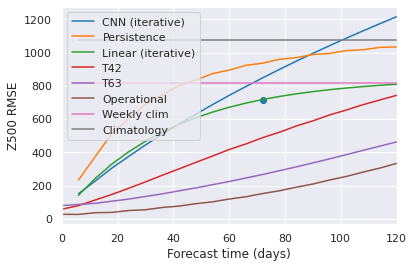

In [113]:
cnn_iter_rmse.z.plot(label = "CNN (iterative)")
persistence_rmse.z.plot(label = "Persistence")
linear_rmse.z.plot(label = "Linear (iterative)")
t42_rmse.z.plot(label = "T42")
t63_rmse.z.plot(label = "T63")
tigge_rmse.z.plot(label = "Operational")
plt.plot(persistence_rmse.lead_time.values, [weekly_clim_rmse.z.values for i in range(len(persistence_rmse.lead_time))], label = "Weekly clim")
plt.plot(persistence_rmse.lead_time.values, [clim_rmse.z.values for i in range(len(persistence_rmse.lead_time))], label = "Climatology")
plt.scatter([72], cnn_dir_72_rmse.z.values)
plt.xlim([0, 120])
plt.xlabel('Forecast time (days)')
plt.ylabel('Z500 RMSE')
plt.title('')
plt.legend(loc = 2)
plt.show()

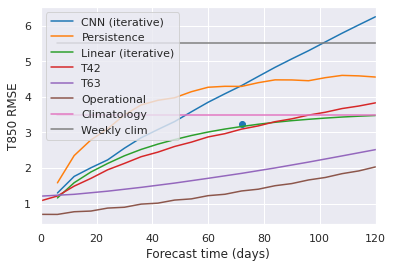

In [114]:
cnn_iter_rmse.t.plot(label = "CNN (iterative)")
persistence_rmse.t.plot(label = "Persistence")
linear_rmse.t.plot(label = "Linear (iterative)")
t42_rmse.t.plot(label = 'T42')
t63_rmse.t.plot(label = 'T63')
tigge_rmse.t.plot(label = "Operational")
plt.plot(persistence_rmse.lead_time.values, [weekly_clim_rmse.t.values for i in range(len(persistence_rmse.lead_time))], label = "Climatology")
plt.plot(persistence_rmse.lead_time.values, [clim_rmse.t.values for i in range(len(persistence_rmse.lead_time))], label = "Weekly clim")
plt.scatter([72], cnn_dir_72_rmse.t.values)
plt.xlim([0, 120])
plt.xlabel('Forecast time (days)')
plt.ylabel('T850 RMSE')
plt.title('')
plt.legend()
plt.show()

In [115]:
print("Persistence 3 days z500")
print(persistence_rmse.z.sel(lead_time = 72).values)

print("Persistence 5 days z500")
print(persistence_rmse.z.sel(lead_time = 120).values)
print(" ")
print("Climatology z500")
print(weekly_clim_rmse.z.values)
print(" ")
print("Weekly climatology z500")
print(clim_rmse.z.values)
print(" ")
print("CNN direct 3days z500")
print(cnn_dir_72_rmse.z.values)
print("CNN iterative 3 days z500")
print(cnn_iter_rmse.z.sel(lead_time = 72).values)
print("CNN iterative 5 days z500")
print(cnn_iter_rmse.z.sel(lead_time = 120).values)
print(" ")
print("Linear iterative 3 days z500")
print(linear_rmse.z.sel(lead_time = 72).values)
print("Linear iterative 5 days z500")
print(linear_rmse.z.sel(lead_time = 120).values)
print(" ")
print("T42 3 days z500")
print(t42_rmse.z.sel(lead_time = 72).values)
print("T42 5 days z500")
print(t42_rmse.z.sel(lead_time = 120).values)
print(" ")
print("Operational 3 days z500")
print(tigge_rmse.z.sel(lead_time = 72).values)
print("Operational 5 days z500")
print(tigge_rmse.z.sel(lead_time = 120).values)

Persistence 3 days z500
936.007854910447
Persistence 5 days z500
1033.2870673490763
 
Climatology z500
815.8162124002182
 
Weekly climatology z500
1075.3658263002544
 
CNN direct 3days z500
713.3428425796859
CNN iterative 3 days z500
847.5628638176454
CNN iterative 5 days z500
1214.671412507698
 
Linear iterative 3 days z500
717.6083527123478
Linear iterative 5 days z500
809.3427309616721
 
T42 3 days z500
488.75903131937594
T42 5 days z500
742.7000257258023
 
Operational 3 days z500
153.09784599719526
Operational 5 days z500
334.1049485981848


In [117]:
print("Persistence 3 days T850")
print(persistence_rmse.t.sel(lead_time = 72).values)

print("Persistence 5 days T850")
print(persistence_rmse.t.sel(lead_time = 120).values)
print(" ")
print("Climatology T850")
print(weekly_clim_rmse.t.values)
print(" ")
print("Weekly climatology T850")
print(clim_rmse.t.values)
print(" ")
print("CNN direct 3days z500")
print(cnn_dir_72_rmse.t.values)
print("CNN iterative 3 days z500")
print(cnn_iter_rmse.t.sel(lead_time = 72).values)
print("CNN iterative 5 days z500")
print(cnn_iter_rmse.t.sel(lead_time = 120).values)
print(" ")
print("Linear iterative 3 days T850")
print(linear_rmse.t.sel(lead_time = 72).values)
print("Linear iterative 5 days T850")
print(linear_rmse.t.sel(lead_time = 120).values)
print(" ")
print("T42 3 days T850")
print(t42_rmse.t.sel(lead_time = 72).values)
print("T42 5 days T850")
print(t42_rmse.t.sel(lead_time = 120).values)
print(" ")
print("Operational 3 days z500")
print(tigge_rmse.t.sel(lead_time = 72).values)
print("Operational 5 days z500")
print(tigge_rmse.t.sel(lead_time = 120).values)

Persistence 3 days T850
4.292918350379879
Persistence 5 days T850
4.556233731401214
 
Climatology T850
3.503484517566649
 
Weekly climatology T850
5.512353749493499
 
CNN direct 3days z500
3.2403093314529006
CNN iterative 3 days z500
4.316092622873898
CNN iterative 5 days z500
6.250509222879882
 
Linear iterative 3 days T850
3.1661298872459596
Linear iterative 5 days T850
3.475969787427173
 
T42 3 days T850
3.0931665087405587
T42 5 days T850
3.831162307569719
 
Operational 3 days z500
1.3554965336600335
Operational 5 days z500
2.0316256111382507
